This jupyter notebook tests the method to find the inflection points of the time series of entropy and bhattacharyya_distance using scipy.interpolate.CubicSpline.

In [3]:
import tensorflow as tf
import argparse
import numpy as np

from calculate_flexibility import (
    calculate_flexibility_measures, 
    visualize_flexibility_measures,
    calculate_inflection_proportion
)

In [4]:
# Define the feature structure of TF_example
def _parse_function(example_proto):
    feature_description = {
        'key': tf.io.FixedLenFeature([], tf.string),
        'label_id': tf.io.FixedLenFeature([], tf.string),
        'ink': tf.io.VarLenFeature(tf.float32),
        'stroke_length': tf.io.VarLenFeature(tf.int64),
        'shape': tf.io.FixedLenFeature([3], tf.int64),
        'num_strokes': tf.io.FixedLenFeature([], tf.int64)
    }

    # Parse the input tf.train.Example proto based on feature_description
    return tf.io.parse_single_example(example_proto, feature_description)

Pre-tained model loaded successfully.


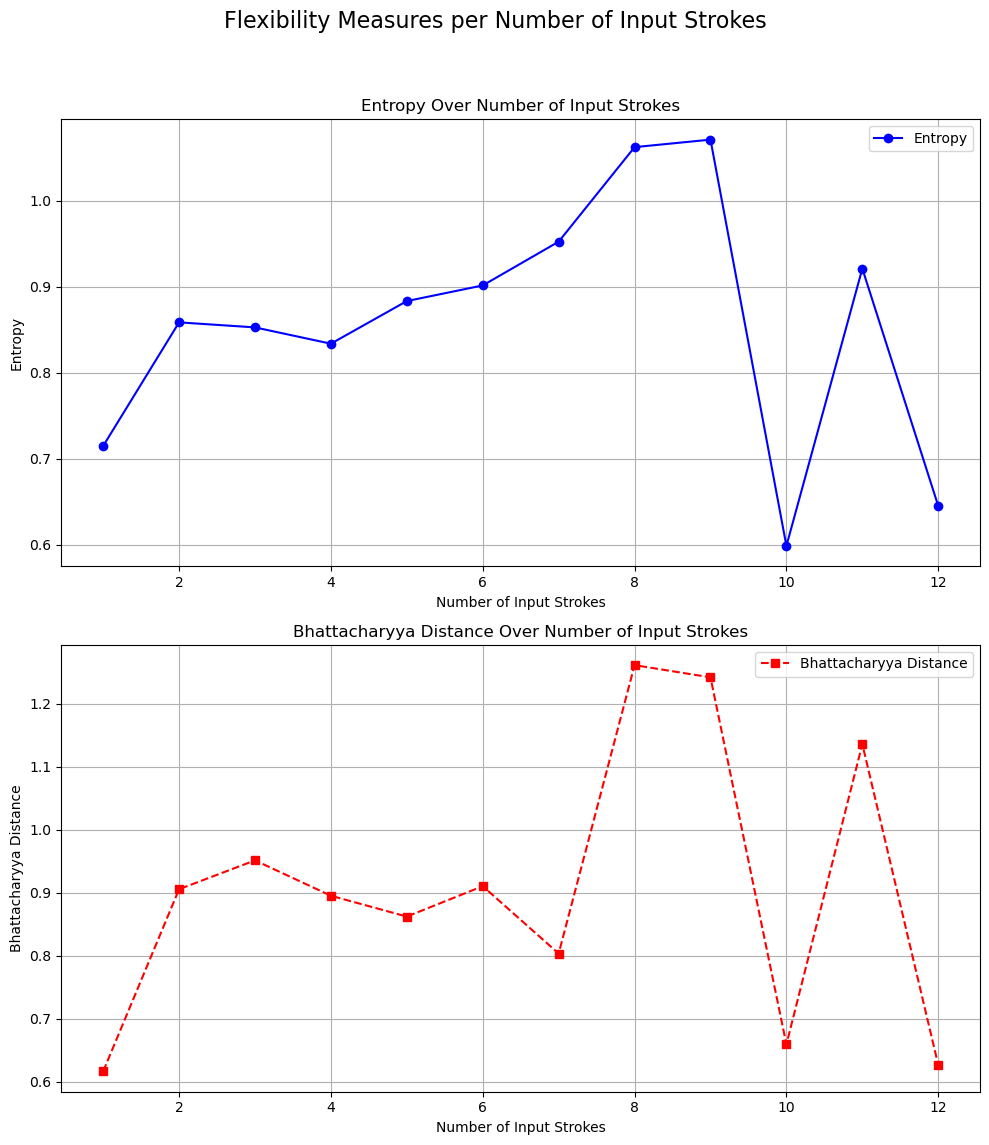

Average Entropy: 0.8580517217384404
Average Bhattacharyya Distance: 0.9058724510454166


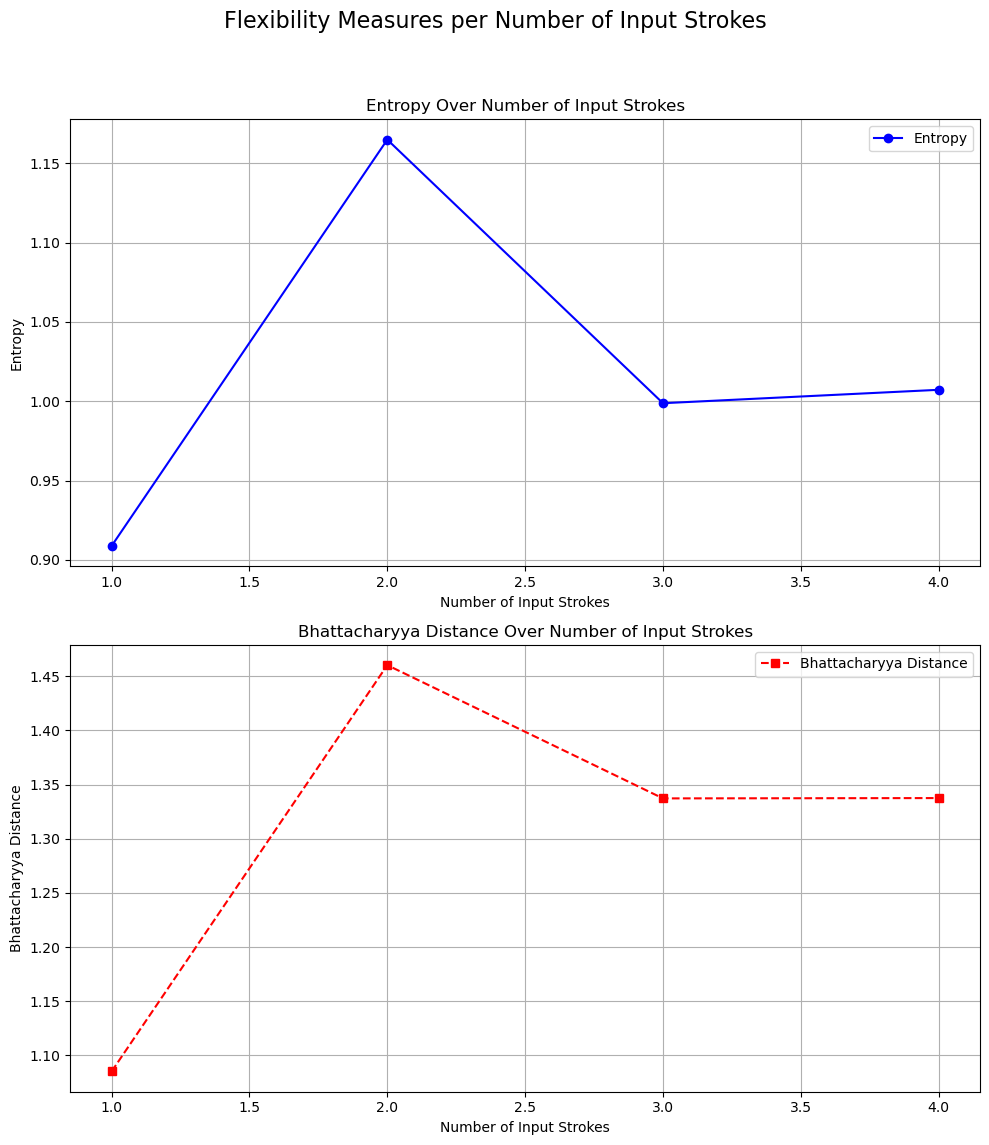

Average Entropy: 1.01993876017311
Average Bhattacharyya Distance: 1.3050956193145287


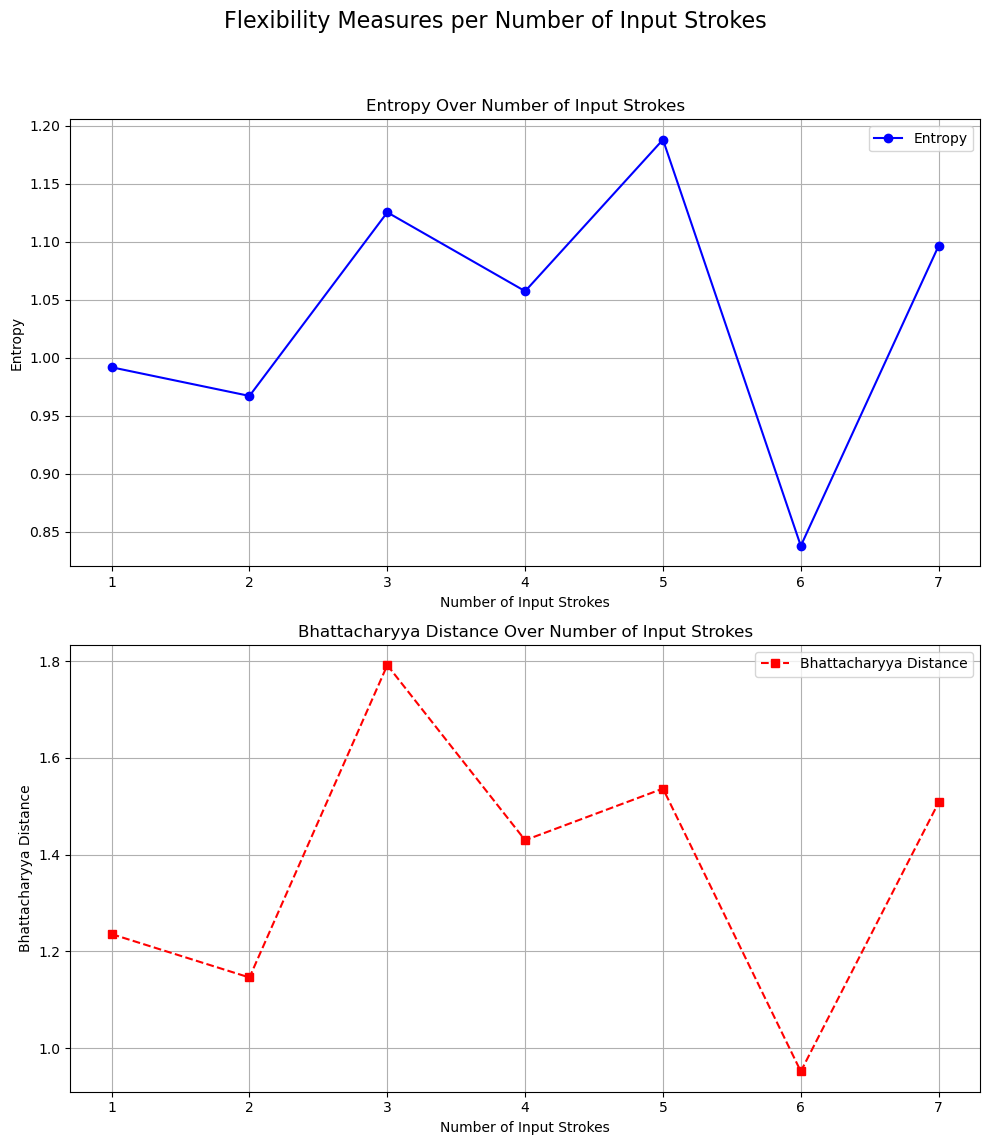

Average Entropy: 1.0378199301797153
Average Bhattacharyya Distance: 1.3715947901310697


In [5]:
# Define constants based on arguments
DATA_DIR = "data"

JSON_FILES = [
    "raw_group_A_drawings.ndjson", 
    "raw_group_B_drawings.ndjson", 
    "raw_group_C_drawings.ndjson"
]

# Load pre-trained CoSE model
model = tf.saved_model.load("../pretrained_model/saved_model_with_signatures")
print("Pre-tained model loaded successfully.")

# Iterate over the drawing files
for f in JSON_FILES:
    drawing_name = f.split(".")[0]
    tfrecord_path = f'data/{drawing_name}-00000-of-00001.tfrecord'
    raw_drawing_dataset = tf.data.TFRecordDataset(tfrecord_path)
    parsed_drawing_dataset = raw_drawing_dataset.map(_parse_function)

    # Iterate over the dataset
    # For now, just test the first drawing
    for parsed_features in parsed_drawing_dataset.take(1):
        ink = tf.sparse.to_dense(parsed_features['ink'])
        # print("Drawing: ", ink)
        shape = parsed_features['shape']
        # print("Shape of Drawing: ", shape)
        stroke_length = tf.sparse.to_dense(parsed_features['stroke_length'])
        # print("Stroke length: ", stroke_length)
        
        # Reshape ink data to original dimensions (num_strokes, max_len, 4)
        reshaped_ink = tf.reshape(ink, shape)

        # Calculate flexibility measures
        entropy_array, bhattacharyya_distance_array = calculate_flexibility_measures(
            model, reshaped_ink, stroke_length
        )

        # Visualize flexibility measures
        visualize_flexibility_measures(entropy_array, bhattacharyya_distance_array)

    # Calculate the average entropy and Bhattacharyya distance
    avg_entropy = np.mean(entropy_array)
    print("Average Entropy:", avg_entropy)  
    avg_bhatt_dist = np.mean(bhattacharyya_distance_array)
    print("Average Bhattacharyya Distance:", avg_bhatt_dist)

# Test entropy time series

In [6]:
x = np.arange(1, len(entropy_array) + 1)
print(x)

y = entropy_array
print(y)

[1 2 3 4 5 6 7]
[0.99186871 0.9671548  1.12551861 1.05751053 1.18822394 0.83778257
 1.09668035]


Potential inflection points (x-values): [2.251256281407035, 3.457286432160804, 4.391959798994975, 5.628140703517587]


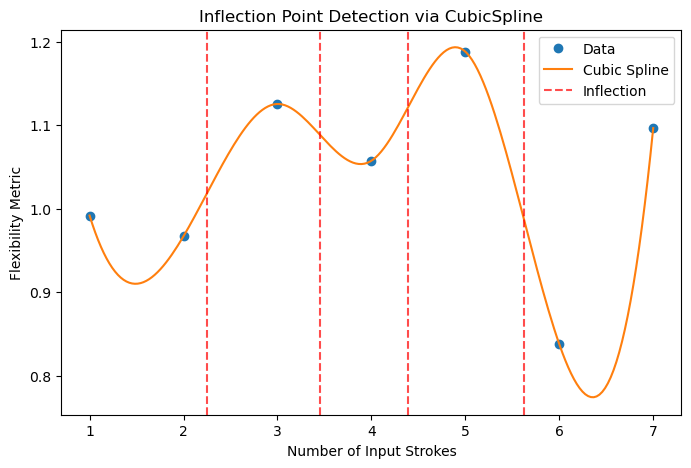

In [7]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# 1. Create a Cubic Spline interpolator
cs = CubicSpline(x, y)

# 2. Evaluate the spline and its second derivative on a dense grid
x_dense = np.linspace(x.min(), x.max(), 200)
y_dense = cs(x_dense)
y2 = cs(x_dense, 2)  # second derivative

# 3. Detect where the second derivative changes sign
inflection_points = []
for i in range(1, len(y2)):
    # Sign change check: if y2[i-1] and y2[i] have different signs
    if y2[i-1] * y2[i] < 0:
        # (Optional) Linear interpolation to refine the x-coordinate
        # For simplicity, we just record the midpoint of i-1 and i
        x_inflect = (x_dense[i-1] + x_dense[i]) / 2
        inflection_points.append(x_inflect)

# Print or store the inflection points
print("Potential inflection points (x-values):", inflection_points)

# 4. Plot to visualize
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'o', label='Data')
plt.plot(x_dense, y_dense, '-', label='Cubic Spline')
for pt in inflection_points:
    plt.axvline(pt, color='red', linestyle='--', alpha=0.7,
                label='Inflection' if pt == inflection_points[0] else None)
plt.xlabel("Number of Input Strokes")
plt.ylabel("Flexibility Metric")
plt.title("Inflection Point Detection via CubicSpline")
plt.legend()
plt.show()

# Test bhattacharyya distance time series

In [8]:
y = bhattacharyya_distance_array
print(y)

[1.23594468 1.14624957 1.79190925 1.4300832  1.53674161 0.95212669
 1.50810852]


Potential inflection points (x-values): [2.251256281407035, 3.5477386934673367, 4.482412060301508, 5.597989949748744]


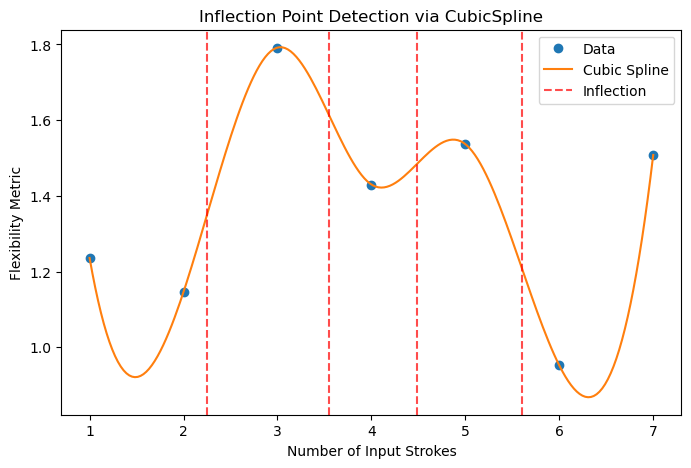

In [9]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# 1. Create a Cubic Spline interpolator
cs = CubicSpline(x, y)

# 2. Evaluate the spline and its second derivative on a dense grid
x_dense = np.linspace(x.min(), x.max(), 200)
y_dense = cs(x_dense)
y2 = cs(x_dense, 2)  # second derivative

# 3. Detect where the second derivative changes sign
inflection_points = []
for i in range(1, len(y2)):
    # Sign change check: if y2[i-1] and y2[i] have different signs
    if y2[i-1] * y2[i] < 0:
        # (Optional) Linear interpolation to refine the x-coordinate
        # For simplicity, we just record the midpoint of i-1 and i
        x_inflect = (x_dense[i-1] + x_dense[i]) / 2
        inflection_points.append(x_inflect)

# Print or store the inflection points
print("Potential inflection points (x-values):", inflection_points)

# 4. Plot to visualize
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'o', label='Data')
plt.plot(x_dense, y_dense, '-', label='Cubic Spline')
for pt in inflection_points:
    plt.axvline(pt, color='red', linestyle='--', alpha=0.7,
                label='Inflection' if pt == inflection_points[0] else None)
plt.xlabel("Number of Input Strokes")
plt.ylabel("Flexibility Metric")
plt.title("Inflection Point Detection via CubicSpline")
plt.legend()
plt.show()